[INFO] Split -> train:(6000, 23), val:(1500, 23), test:(22500, 23)
[INFO] Ratio y=1 -> train:0.221  val:0.221  test:0.221
[BEST-QKSVM@VAL] params={'reps': 1, 'alpha': 0.7, 'gamma': 2.0, 'C': 2.0, 'thr': 0.12002842987996565} | PR-AUC=0.477 F1*=0.517 AUC=0.745
[BEST-RBF @VAL] params={'C': 1.0, 'gamma': 'scale', 'thr': 0.13622403884784628} | PR-AUC=0.495 F1*=0.520 AUC=0.753

== TEST summary (threshold from VALIDATION) ==
{'model': 'QKSVM', 'auc': 0.73576288626707, 'ap': 0.4532207873189018, 'f1': 0.49609171443460137, 'acc': 0.7421333333333333}
{'model': 'RBF@PCA', 'auc': 0.7352297025829172, 'ap': 0.4640190620535112, 'f1': 0.4912509307520477, 'acc': 0.7570666666666667}

== Classification report (QKSVM @ threshold*) ==
              precision    recall  f1-score   support

           0      0.867     0.790     0.827     17523
           1      0.437     0.574     0.496      4977

    accuracy                          0.742     22500
   macro avg      0.652     0.682     0.661     22500
weigh

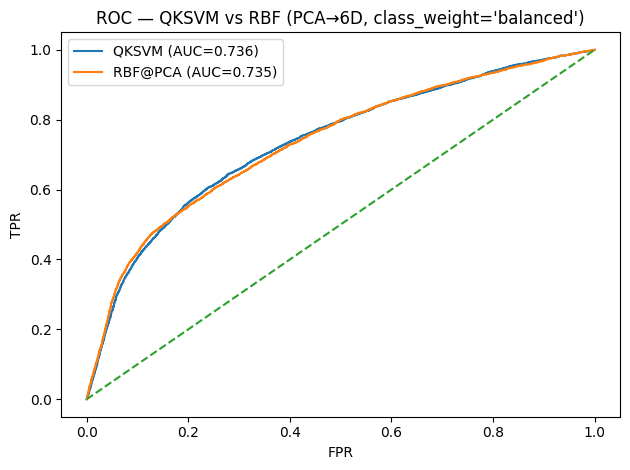

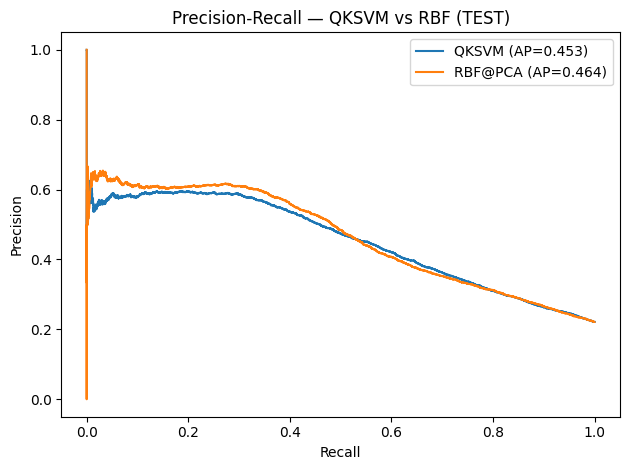

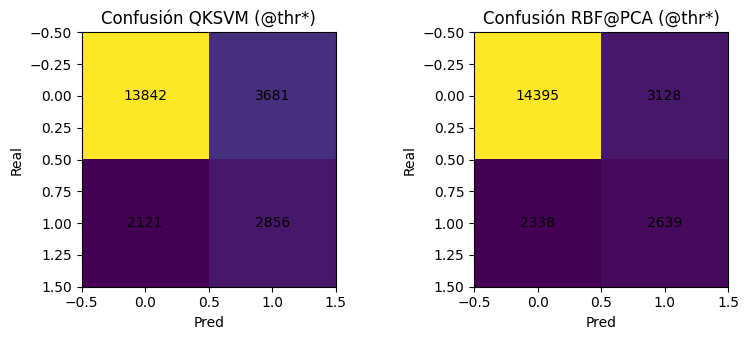

In [12]:
# QKSVM vs SVM-RBF en Default of Credit Card Clients (UCI), con:
# - class_weight='balanced'
# - selección de umbral por F1 en validación con curva PR
# - comparación justa: ambos en mismo PCA -> n_qubits
# Referencias: UCI id=350; scikit-learn class_weight/PR; Qiskit kernels; Havlíček et al.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, classification_report, confusion_matrix
)

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# ============= Config reproducible =============
SEED = 0
TRAIN_FRACTION = 0.25          # 25% del dataset para train+val (estratificado)
VAL_FRACTION   = 0.20          # 20% de (train+val) reservado para validación (para umbral/hiperparámetros)
N_QUBITS       = 6             # nº componentes PCA -> nº qubits (5–7 razonable)
# Grids comedidos
Q_REPS   = [1, 2]
Q_ALPHA  = [0.5, 0.7, 1.0]
Q_GAMMA  = [2.0, 3.0]
Q_C_LIST = [1.0, 2.0, 5.0]
RBF_C    = [1.0, 2.0, 5.0]
RBF_G    = ["scale", "auto"]

# ============= Utilidades métricas/umbral =============
def pick_f1_threshold(y_true, scores):
    """Devuelve (t*, f1_val, prec, rec) maximizando F1 en validación."""
    p, r, t = precision_recall_curve(y_true, scores)
    # thresholds tiene len = len(p) - 1
    f1s = 2*p[:-1]*r[:-1] / (p[:-1]+r[:-1] + 1e-12)
    i = np.argmax(f1s)
    return float(t[i]), float(f1s[i]), float(p[:-1][i]), float(r[:-1][i])

def report_block(name, y_true, scores, y_hat_thresh):
    auc = roc_auc_score(y_true, scores)
    ap  = average_precision_score(y_true, scores)
    f1  = f1_score(y_true, y_hat_thresh)
    acc = accuracy_score(y_true, y_hat_thresh)
    return dict(model=name, auc=auc, ap=ap, f1=f1, acc=acc)

# ============= 1) Datos UCI =============
ds = fetch_ucirepo(id=350)  # Default of Credit Card Clients
X = ds.data.features.copy()
y = ds.data.targets.copy().iloc[:,0].astype(int)
X = X.drop(columns=["ID"], errors="ignore")

# Split global: train+val / test (estratificado)
X_trv_raw, X_te_raw, y_trv, y_te = train_test_split(
    X, y, train_size=TRAIN_FRACTION, stratify=y, random_state=SEED
)

# Split interno: train / val (para seleccionar hiperparámetros y umbrales)
X_tr_raw, X_val_raw, y_tr, y_val = train_test_split(
    X_trv_raw, y_trv, test_size=VAL_FRACTION, stratify=y_trv, random_state=SEED
)

print(f"[INFO] Split -> train:{X_tr_raw.shape}, val:{X_val_raw.shape}, test:{X_te_raw.shape}")
print(f"[INFO] Ratio y=1 -> train:{y_tr.mean():.3f}  val:{y_val.mean():.3f}  test:{y_te.mean():.3f}")

# ============= 2) Preprocesado (fit SOLO en train) =============
std0 = StandardScaler()
X_tr0  = std0.fit_transform(X_tr_raw)
X_val0 = std0.transform(X_val_raw)
X_te0  = std0.transform(X_te_raw)

pca = PCA(n_components=N_QUBITS, random_state=SEED)
Z_tr  = pca.fit_transform(X_tr0)
Z_val = pca.transform(X_val0)
Z_te  = pca.transform(X_te0)

# Espacio clásico (RBF): estandariza el PCA
std_pca = StandardScaler()
Z_tr_std  = std_pca.fit_transform(Z_tr)
Z_val_std = std_pca.transform(Z_val)
Z_te_std  = std_pca.transform(Z_te)

# Espacio cuántico (QKSVM): mapea a ángulos [0, π]
ang = MinMaxScaler(feature_range=(0, np.pi))
Z_tr_ang  = ang.fit_transform(Z_tr)
Z_val_ang = ang.transform(Z_val)
Z_te_ang  = ang.transform(Z_te)

n_qubits = Z_tr_ang.shape[1]

# ============= 3) Infraestructura QKSVM =============
def zz_feature_circuit(x, n_qubits, reps=2, alpha=1.0, gamma=2.0):
    qc = QuantumCircuit(n_qubits)
    for _ in range(reps):
        for q in range(n_qubits):
            qc.h(q)
        for q in range(n_qubits):
            a = alpha * float(x[q])
            qc.rz(a, q); qc.ry(2*a, q)
        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                qc.rzz(gamma * float(x[i]) * float(x[j]), i, j)
    return qc

def embed_statevectors(Xa, n_qubits, reps=2, alpha=1.0, gamma=2.0):
    S = np.empty((len(Xa), 2**n_qubits), dtype=complex)
    for i, x in enumerate(Xa):
        S[i,:] = Statevector.from_instruction(
            zz_feature_circuit(x, n_qubits, reps, alpha, gamma)
        ).data
    return S

def kernel_from_states(SA, SB):
    return np.abs(SA @ SB.conj().T)**2

def center_kernel(K_tr, K_te=None):
    n = K_tr.shape[0]
    one = np.ones((n,n))/n
    Kc_tr = K_tr - one@K_tr - K_tr@one + one@K_tr@one
    if K_te is None:
        return Kc_tr, None
    m = K_te.shape[0]
    one_mn = np.ones((m,n))/n
    Kc_te = K_te - one_mn@K_tr - K_te@one + one_mn@K_tr@one
    return Kc_tr, Kc_te

# ============= 4) Búsqueda en validación (QKSVM y RBF) =============
best_q = None
best_q_cache = {}
for reps in Q_REPS:
    for alpha in Q_ALPHA:
        for gamma in Q_GAMMA:
            # Embeddings/Kernels con train como "referencia"
            S_tr  = embed_statevectors(Z_tr_ang,  n_qubits, reps, alpha, gamma)
            S_val = embed_statevectors(Z_val_ang, n_qubits, reps, alpha, gamma)
            S_te  = embed_statevectors(Z_te_ang,  n_qubits, reps, alpha, gamma)

            K_tr  = kernel_from_states(S_tr, S_tr)
            K_val = kernel_from_states(S_val, S_tr)
            K_te  = kernel_from_states(S_te, S_tr)
            Kc_tr, Kc_val = center_kernel(K_tr, K_val)
            _,    Kc_te   = center_kernel(K_tr, K_te)

            for Cq in Q_C_LIST:
                qsvm = SVC(kernel='precomputed', C=Cq, class_weight='balanced', random_state=SEED)
                qsvm.fit(Kc_tr, y_tr)
                # Validación: scores y umbral óptimo por F1
                val_scores = qsvm.decision_function(Kc_val)
                t_q, f1v_q, pv_q, rv_q = pick_f1_threshold(y_val, val_scores)
                # Métricas de selección (val)
                ap_q_val  = average_precision_score(y_val, val_scores)
                auc_q_val = roc_auc_score(y_val, val_scores)
                sel = (ap_q_val, f1v_q, auc_q_val)  # priorizo PR-AUC, luego F1
                if (best_q is None) or (sel > best_q):
                    best_q = sel
                    best_q_cache = dict(
                        params=dict(reps=reps, alpha=alpha, gamma=gamma, C=Cq, thr=t_q),
                        objects=dict(qsvm=qsvm, Kc_tr=Kc_tr, Kc_te=Kc_te),
                        valid=dict(ap=ap_q_val, f1=f1v_q, auc=auc_q_val, p=pv_q, r=rv_q)
                    )

# RBF@PCA (mismo espacio PCA)
best_rbf = None
best_rbf_cache = {}
for C in RBF_C:
    for g in RBF_G:
        rbf = SVC(kernel='rbf', C=C, gamma=g, class_weight='balanced', random_state=SEED)
        rbf.fit(Z_tr_std, y_tr)
        val_scores = rbf.decision_function(Z_val_std)
        t_r, f1v_r, pv_r, rv_r = pick_f1_threshold(y_val, val_scores)
        ap_r_val  = average_precision_score(y_val, val_scores)
        auc_r_val = roc_auc_score(y_val, val_scores)
        sel = (ap_r_val, f1v_r, auc_r_val)
        if (best_rbf is None) or (sel > best_rbf):
            best_rbf = sel
            best_rbf_cache = dict(
                params=dict(C=C, gamma=g, thr=t_r),
                objects=dict(rbf=rbf),
                valid=dict(ap=ap_r_val, f1=f1v_r, auc=auc_r_val, p=pv_r, r=rv_r)
            )

print(f"[BEST-QKSVM@VAL] params={best_q_cache['params']} | PR-AUC={best_q_cache['valid']['ap']:.3f} F1*={best_q_cache['valid']['f1']:.3f} AUC={best_q_cache['valid']['auc']:.3f}")
print(f"[BEST-RBF @VAL] params={best_rbf_cache['params']} | PR-AUC={best_rbf_cache['valid']['ap']:.3f} F1*={best_rbf_cache['valid']['f1']:.3f} AUC={best_rbf_cache['valid']['auc']:.3f}")

# ============= 5) Evaluación en TEST (umbral fijado en validación) =============
# QKSVM
qsvm = best_q_cache['objects']['qsvm']; Kc_te = best_q_cache['objects']['Kc_te']
scores_q = qsvm.decision_function(Kc_te)
thr_q    = best_q_cache['params']['thr']
yq_opt   = (scores_q >= thr_q).astype(int)
rep_q    = report_block("QKSVM", y_te, scores_q, yq_opt)

# RBF
rbf = best_rbf_cache['objects']['rbf']
scores_r = rbf.decision_function(Z_te_std)
thr_r    = best_rbf_cache['params']['thr']
yr_opt   = (scores_r >= thr_r).astype(int)
rep_r    = report_block("RBF@PCA", y_te, scores_r, yr_opt)

print("\n== TEST summary (threshold from VALIDATION) ==")
print(rep_q)
print(rep_r)

print("\n== Classification report (QKSVM @ threshold*) ==")
print(classification_report(y_te, yq_opt, digits=3))
print("\n== Classification report (RBF@PCA @ threshold*) ==")
print(classification_report(y_te, yr_opt, digits=3))

# ============= 6) Gráficas (ROC y PR en TEST) =============
# ROC
fpr_q, tpr_q, _ = roc_curve(y_te, scores_q)
fpr_r, tpr_r, _ = roc_curve(y_te, scores_r)
plt.figure()
plt.plot(fpr_q, tpr_q, label=f"QKSVM (AUC={rep_q['auc']:.3f})")
plt.plot(fpr_r, tpr_r, label=f"RBF@PCA (AUC={rep_r['auc']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.title(f"ROC — QKSVM vs RBF (PCA→{n_qubits}D, class_weight='balanced')")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

# PR
p_q, r_q, _ = precision_recall_curve(y_te, scores_q)
p_r, r_r, _ = precision_recall_curve(y_te, scores_r)
ap_q = average_precision_score(y_te, scores_q)
ap_r = average_precision_score(y_te, scores_r)
plt.figure()
plt.plot(r_q, p_q, label=f"QKSVM (AP={ap_q:.3f})")
plt.plot(r_r, p_r, label=f"RBF@PCA (AP={ap_r:.3f})")
plt.title("Precision-Recall — QKSVM vs RBF (TEST)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout(); plt.show()

# Confusión (TEST) a umbral óptimo
cm_q = confusion_matrix(y_te, yq_opt)
cm_r = confusion_matrix(y_te, yr_opt)
fig, axs = plt.subplots(1,2, figsize=(8,3.5))
axs[0].imshow(cm_q); axs[0].set_title("Confusión QKSVM (@thr*)"); axs[0].set_xlabel("Pred"); axs[0].set_ylabel("Real")
for i in range(cm_q.shape[0]):
    for j in range(cm_q.shape[1]):
        axs[0].text(j, i, int(cm_q[i,j]), ha='center', va='center')
axs[1].imshow(cm_r); axs[1].set_title("Confusión RBF@PCA (@thr*)"); axs[1].set_xlabel("Pred"); axs[1].set_ylabel("Real")
for i in range(cm_r.shape[0]):
    for j in range(cm_r.shape[1]):
        axs[1].text(j, i, int(cm_r[i,j]), ha='center', va='center')
plt.tight_layout(); plt.show()
